# Understanding Subject Domain

https://en.wikipedia.org/wiki/Combined_cycle_power_plant

From Course Notes:

Definitions & Data Summary
- Temperature (T) in the range 1.81°C to 37.11°C,
- Ambient Pressure (AP) in the range 992.89-1033.30 milibar,
- Relative Humidity (RH) in the range 25.56% to 100.16%
- Exhaust Vacuum (V) in the range 25.36-81.56 cm Hg
- Net hourly electrical energy output (PE) 420.26-495.76 MW (Target we are trying to predict)

Notes:
* Temperature is an indicator of efficiency of the power process, higher means more efficiency
* Exhaust Vacuum measures the level of vacuum and thus turbine efficiency, a higher value means less back pressure and thus better efficiency
* Ambient Pressure affect the overall performance and efficiency of the location in which the plant is operated in
* Relative Humidity affects the ease of combustion, and thus low humidity will help with efficiency
* Energy Output measures the output from the processes

# Data Gathering

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('CCPP_data.csv')

In [3]:
print(df.head())

      AT      V       AP     RH      PE
0  14.96  41.76  1024.07  73.17  463.26
1  25.18  62.96  1020.04  59.08  444.37
2   5.11  39.40  1012.16  92.14  488.56
3  20.86  57.32  1010.24  76.64  446.48
4  10.82  37.50  1009.23  96.62  473.90


In [4]:
df.describe(include='all')

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


Qualitative/Quantitative Data: The summary shows continuous data. As the data consists of continuous values and not discrete ones, we should use float datatypes. The minimum seems normal at a glance with no negative or extreme values. 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


verified datatype of float64 

# Machine Learning Approach and Output Metric to evaluate Performance

The ML approach will be supervised learning using regression. For the regression task to predict the continuous variable, we can consider use one or more of the following metrics to evaluate performance: 

**Mean Absolute Error**: average of absolute differences between predicted and actual values

**Mean Squared Error**: average of square of errors, useful when large errors are significantly worse off than smaller ones

**Root Mean Squared Error**: helps to understand the magnitude of error 

**R-squared**: variance in dependent variable , as an indicator of fit of the predictions 

**Mean Absolute Percentage Error**: as a proxy of the model's performance that shows accuracy as a percentage of the error

# Visualize to Explore

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

Calculate their correlations first

In [7]:
corr = df.corr()

<Axes: >

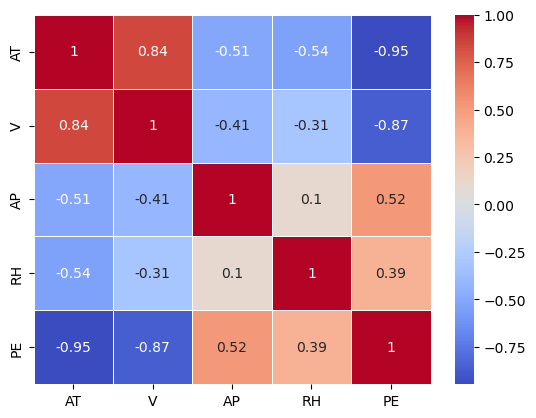

In [8]:
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidth=.5)

* AT and V: 0.84 suggests a strong positive relationship, meaning that as the ambient temperature (AT) increases, vacuum also tends to increase.
* AT and PE: -0.95 indicates a strong negative relationship, suggesting that as the ambient temperature (AT) increases, Energy Output tends to decrease.
* V and PE: -0.87 suggests that as V increases, PE tends to decrease significantly.
* AP and PE: 0.52 indicates a moderate positive relationship between AP and PE and Energy Output
* RH and PE: 0.39 suggests a weak positive relationship between RH and PE Energy Output


Might want to consider: <span style='color:green'> ** drop RH due to weak relationship ** </span>

# Find out the shape of the data and if there are skews 

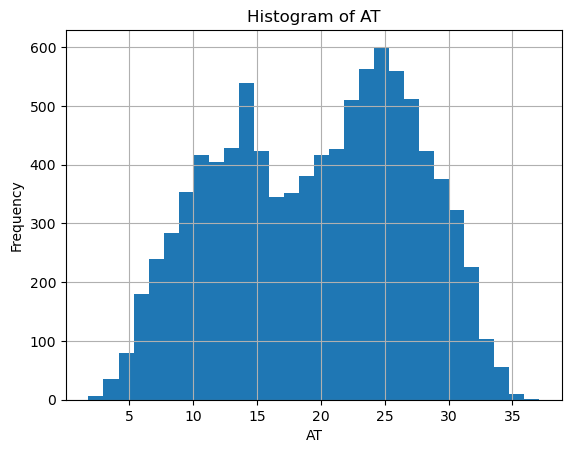

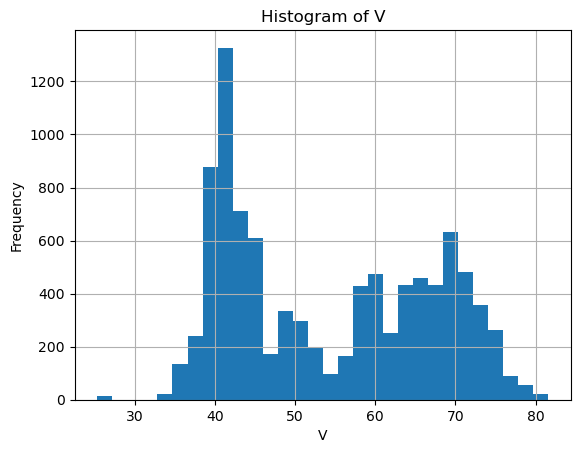

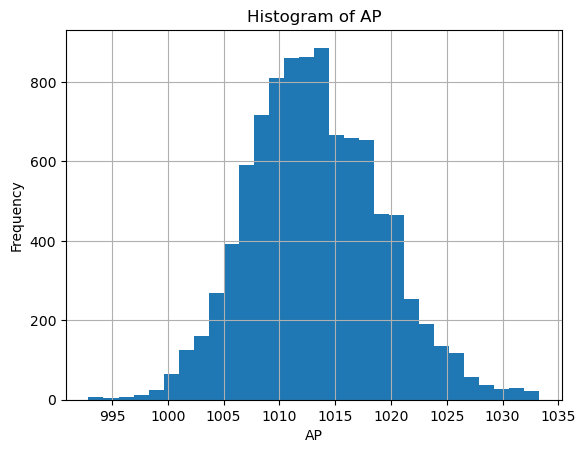

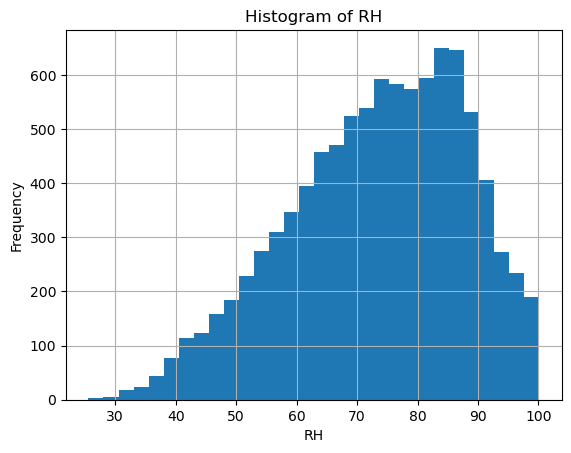

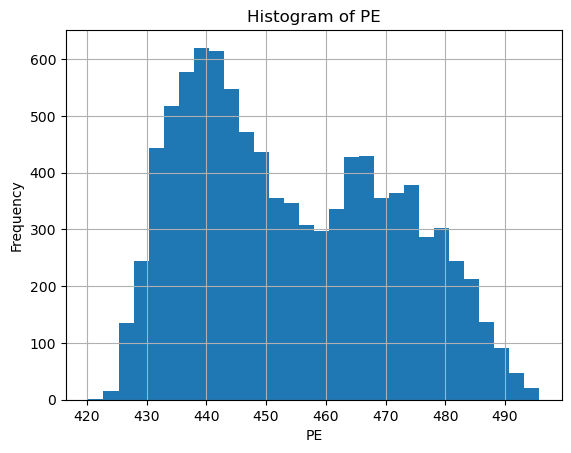

In [9]:

for column in df.columns:
    plt.figure()  # This ensures a new figure is created for each histogram
    df[column].hist(bins=30)  # Adjust the number of bins as necessary
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()


# Determine the Skew

In [10]:
from scipy.stats import skew

In [11]:
skewness = skew(df, bias=False)  # Set bias to False for the sample correction
print(f"Skewness of the dataset: {skewness}")

Skewness of the dataset: [-0.13639305  0.19852101  0.26544469 -0.43183875  0.30650944]


The skewness are within acceptable range of -0.5 and 0.5 to be considered symmetric

# Determine the Outliers

In [12]:
def calculate_outliers(df):
    outlier_indices = []  # List to hold indices of outliers across all columns
    outliers = {}  # Dictionary to hold outlier dataframes for each column
    
    for column in df.columns:
        if df[column].dtype.kind in 'bifc':  # Check if the column is numeric
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Find outliers for the current column
            column_outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
            
            # If there are outliers, add their indices to the list and store the dataframe
            if not column_outliers.empty:
                outlier_indices.extend(column_outliers.index.tolist())
                outliers[column] = column_outliers
    
    # Calculate the total number of unique outliers across all columns
    total_unique_outliers = len(set(outlier_indices))
    
    # Calculate the fraction of outliers in the dataset
    outliers_fraction = total_unique_outliers / len(df)
    
    return outliers, total_unique_outliers, outliers_fraction

# Use the updated function
outliers_dict, total_unique_outliers, outliers_fraction = calculate_outliers(df)

# Print the outliers for each column
for column, outlier_df in outliers_dict.items():
    print(f"Outliers for {column}:\n{outlier_df}\n")

# Print the total number of unique outliers across the dataset
print(f"Total number of unique outliers across the dataset: {total_unique_outliers}")

# Print the fraction of outliers in the dataset
print(f"Fraction of outliers in the dataset: {outliers_fraction}")

Outliers for AP:
         AT      V       AP     RH      PE
238   13.49  44.47  1030.46  69.49  466.66
319    9.25  41.82  1033.25  74.73  478.48
368   13.49  44.47  1030.18  69.15  468.46
536    9.11  40.02  1031.10  83.02  479.03
571    5.97  36.25  1029.65  86.74  487.03
...     ...    ...      ...    ...     ...
9068  15.62  41.23   992.89  83.99  463.21
9159   7.20  40.02  1031.71  69.89  480.53
9267  12.51  41.92  1031.21  64.66  468.41
9342   8.72  40.02  1031.32  78.09  477.86
9366  14.65  41.92  1030.61  63.07  464.95

[88 rows x 5 columns]

Outliers for RH:
         AT      V       AP     RH      PE
789   34.30  74.67  1015.98  25.89  427.84
2262  33.94  74.67  1015.94  28.16  427.98
3603  19.78  44.71  1015.70  29.43  465.49
4367  34.65  74.67  1016.03  26.67  427.69
6472  33.83  67.90  1005.94  29.86  428.12
7983  19.31  44.71  1016.13  30.59  463.00
8061  34.24  74.67  1016.24  25.56  425.58
8737  18.76  44.71  1015.15  30.83  462.18
8751  19.32  44.71  1015.30  28.81  464

The total number of outliers are insignificant, but I'll still be removing them as there are not that many to impact the data

# Data cleaning

In [13]:
def remove_outliers(df):
    outlier_indices = []  # List to hold indices of outliers across all columns
    
    for column in df.columns:
        if df[column].dtype.kind in 'bifc':  # Check if the column is numeric
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Find outliers for the current column
            column_outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
            
            # If there are outliers, add their indices to the list
            if not column_outliers.empty:
                outlier_indices.extend(column_outliers.index.tolist())
    
    # Calculate the total number of unique outliers across all columns
    total_unique_outliers = len(set(outlier_indices))
    
    # Remove the outliers from the DataFrame
    df_cleaned = df.drop(index=set(outlier_indices))
    
    return df_cleaned, total_unique_outliers

# Use the updated function to remove outliers
df_cleaned, total_unique_outliers = remove_outliers(df)

# Standardize the Features

In [14]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load your data
df = pd.read_csv('CCPP_data.csv')

# Initialize a StandardScaler object
scaler = StandardScaler()

# Fit and transform the data
# Assuming all columns except the target variable are features
# Exclude target variable from this operation
features = df.drop('PE', axis=1)  
df_scaled_features = scaler.fit_transform(features)

# Create a new DataFrame with the scaled features
df_scaled = pd.DataFrame(df_scaled_features, columns=features.columns)

# Add the target variable back 
df_scaled['PE'] = df['PE']

# Now df_scaled contains the standardized features along with the target variable


Scaling the features, it might improve performance of the algorithms 

In [15]:
df_scaled.describe(include = 'all')

,AT,V,AP,RH,PE
count,9.568000e+03,9.568000e+03,9.568000e+03,9.568000e+03,9568.000000
mean,-1.845421e-16,-1.927110e-16,5.472211e-15,-3.375227e-16,454.365009
std,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00,17.066995
min,-2.394126e+00,-2.277901e+00,-3.430019e+00,-3.270589e+00,420.260000
25%,-8.240958e-01,-9.888705e-01,-7.003615e-01,-6.836860e-01,439.750000
50%,9.309729e-02,-1.751604e-01,-5.373067e-02,1.141150e-01,451.550000
75%,8.143721e-01,9.627745e-01,6.737290e-01,7.891378e-01,468.430000
max,2.342804e+00,2.144779e+00,3.374760e+00,1.839173e+00,495.760000


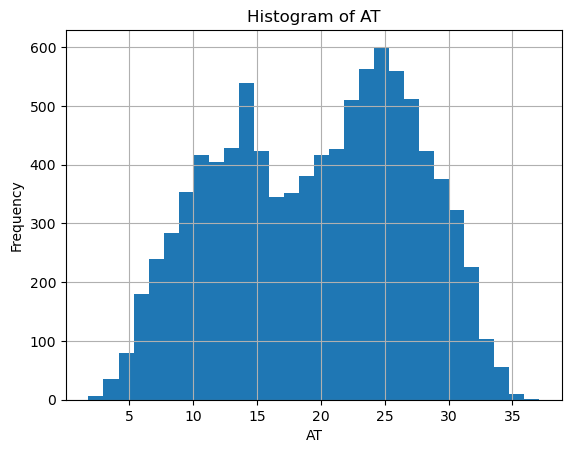

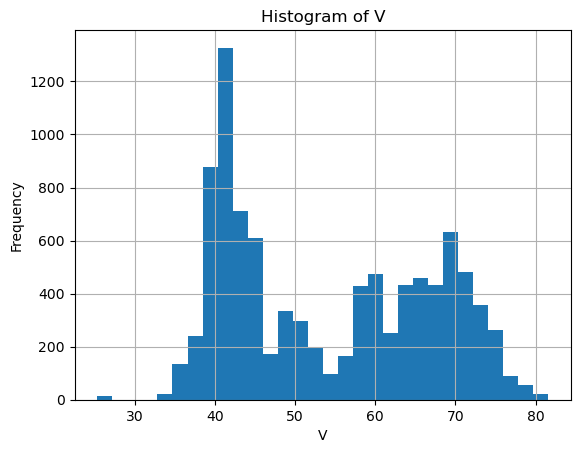

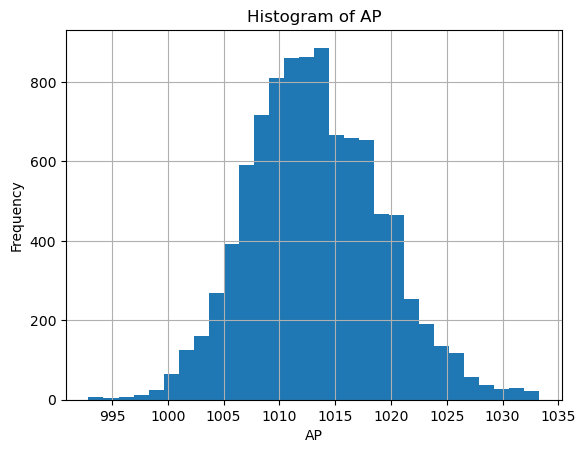

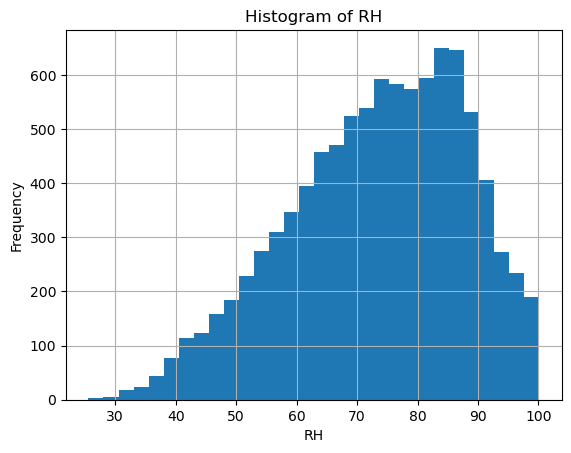

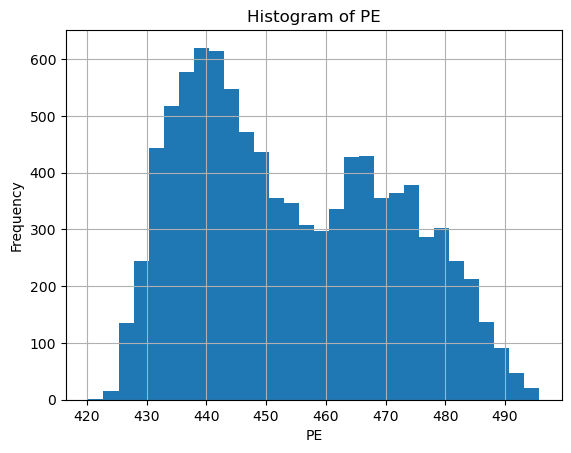

In [16]:

for column in df_scaled.columns:
    plt.figure()  # This ensures a new figure is created for each histogram
    df[column].hist(bins=30)  # Adjust the number of bins as necessary
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()


# Split Data, Validate and Evaluate ML Models

In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tune_sklearn import TuneSearchCV

def compare_regression_models(df_scaled):
    # Splitting the dataframe into features and target variable
    X = df_scaled.drop('PE', axis=1)  
    y = df_scaled['PE']
    
    # Splitting into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Defining the models and hyperparameters to test
    models = {
        'GradientBoostingRegressor': GradientBoostingRegressor(),
        'RandomForestRegressor': RandomForestRegressor(),
        'SVR': SVR()
    }
    hyperparameters = {
        'GradientBoostingRegressor': {
            'n_estimators': [100, 500],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 8]
        },
        'RandomForestRegressor': {
            'n_estimators': [100, 200],
            'max_depth': [None, 3, 5, 10],
            'min_samples_split': [2, 5, 10]
        },
        'SVR': {
            'C': [0.1, 1.0, 10.0],
            'kernel': ['linear', 'rbf']
        }
    }
    
    # Using TuneSearchCV for hyperparameter tuning
    model_scores = []
    for name, model in models.items():
        param_dists = hyperparameters.get(name, {})
        tune_search = TuneSearchCV(
            model,
            param_distributions=param_dists,
            n_trials=10,  # Number of trials to run 
            scoring='neg_mean_squared_error',
            cv=5,  # 5-Fold Cross-Validation
            random_state=42
        )
        tune_search.fit(X_train, y_train)
        best_model = tune_search.best_estimator_
        y_pred = best_model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        model_scores.append((name, mse, mae, rmse, r2))
    
    # Sort models based on the MSE score
    model_scores.sort(key=lambda x: x[1])
    
    # Display the results
    for model_name, mse, mae, rmse, r2 in model_scores:
        print(f"{model_name}: MSE = {mse:.4f}, MAE = {mae:.4f}, RMSE = {rmse:.4f}, R-squared = {r2:.4f}")

# Call the function 
# compare_regression_models(df_scaled)

In [18]:
compare_regression_models(df_scaled)

(_Trainable pid=9722) /home/zac/miniforge3/envs/mllearn/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead. [repeated 10x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(_Trainable pid=9722)   warnings.warn( [repeated 10x across cluster]


# Summary

GradientBoostingRegressor is the best performer with an R-squared of 97.11%, meaning it can explain bout 97.11% of the variance in the outcomes. Has the lowest RMSE of 2.8977 and MAE of 2.0836, which indicates its predictions are quite close to the actual values. RandomForestRegressor comes in slightly behind. 